# Лабораторна робота №1. Лінійна регресія
## Виконав студент групи КМ-91мп
## Галета М.С.
## Завдання на лабораторну роботу
<img src="task.png">

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

%matplotlib inline

## Зчитування датасету

In [2]:
df = pd.read_csv('MP-04-Galeta.csv', delimiter=';', names=['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'y'])

X_train = df.iloc[:200, :-1].values
X_test = df.iloc[200:250, :-1].values
y_train = df['y'].iloc[:200].values.reshape((200, 1))
y_test = df['y'].iloc[200:250].values.reshape((50, 1))

## Центрування і стандартизація даних
$$X_{new} = \frac{X - \mu}{\sigma}$$

In [3]:
class Scaler:
    def __init__(self):
        self.mean = None
        self.std = None
    
    def fit(self, X):
        self.mean = np.mean(X, axis=0, keepdims=True)
        self.std = np.std(X, axis=0, keepdims=True)
        
    def transform(self, X):
        X_new = (X - self.mean)/self.std
        return X_new
    
    def fit_transform(self, X):
        self.mean = np.mean(X, axis=0, keepdims=True)
        self.std = np.std(X, axis=0, keepdims=True)
        X_new = (X - self.mean)/self.std
        return X_new

In [4]:
sc = Scaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Графіки залежності окремо кожної з ознак від Y

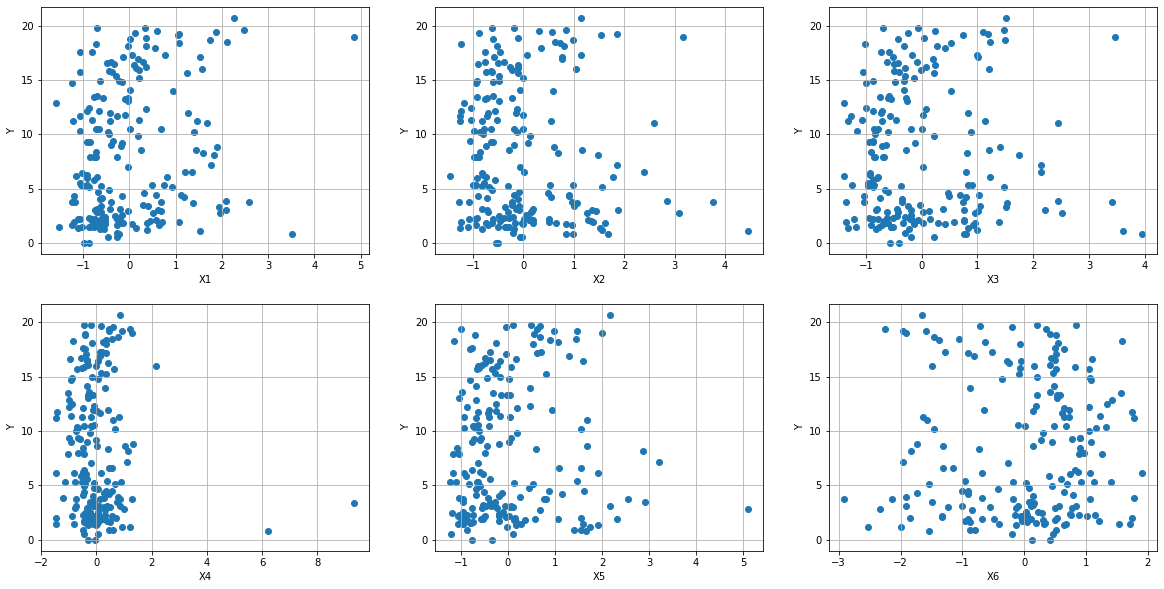

In [5]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))

xlabel = 1
for i in range(2):
    for j in range(3):
        ax[i][j].set_xlabel('X'+str(xlabel))
        ax[i][j].set_ylabel('Y')
        ax[i][j].grid(True)
        ax[i][j].scatter(X_train[:, xlabel-1], y_train)
        xlabel += 1
        
plt.show()

## Додавання фіктивного стовпчика з одиниць для реалізації таким чином вільного коефіцієнта регресії

In [6]:
X_train = np.concatenate((np.ones((200,1)), X_train), axis=1)
X_test = np.concatenate((np.ones((50,1)), X_test), axis=1)

## Модель лінійної регресії методом найменших квадратів
$$coefs = (X^TX)^{-1}X^Ty$$

In [7]:
coefs = (np.linalg.pinv(X_train.T @ X_train) @ X_train.T) @ y_train
df_coefs = pd.DataFrame(columns=['b', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6'], data=coefs.reshape((1, 7)))
print("Коефіцієнти регресії")
display(df_coefs)

Коефіцієнти регресії


,b,w1,w2,w3,w4,w5,w6
0,8.189645,8.412788,-0.157077,-6.709854,-1.172603,0.535967,0.489362


## Перевірка статистичної значимості коефіцієнтів за Стьюдентом
$$S = \sqrt{\frac{\sum_{i=0}^n (y_i - y_{pred\_i})}{n-m-1}}$$

$$S_\beta = S\sqrt{diag((X^TX)^{-1})}$$

$$t_\beta = \frac{coef_i}{S_\beta}$$

$$Якщо\;|t_\beta| > t_{табл.}\;отже\;відповідний\;коефіцієнт\;є\;значимим$$

In [8]:
def statistical_significance(X, y, coefs, n, m):
    y_pred = X @ coefs
    
    s = np.sqrt(np.sum((y-y_pred)**2)/(n-m-1))
    s_beta = s*np.sqrt(np.diag(np.linalg.pinv(X.T @ X)))
    
    t_beta = np.hstack(coefs)/s_beta
    
    return t_beta, y_pred

In [9]:
t_table = 1.6602
t_beta, y_pred = statistical_significance(X_train, y_train, coefs, 200, 6)

In [10]:
sign = pd.DataFrame(columns=['b', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6'], data=np.array([np.abs(t_beta) > t_table], dtype=int))
print("Статистична значимість (1 якщо значимий, 0 якщо незначимий)")
display(sign)

Статистична значимість (1 якщо значимий, 0 якщо незначимий)


,b,w1,w2,w3,w4,w5,w6
0,1,1,0,1,1,0,0


## Перевірка адекватності моделі за допомогою коефіцієнта множинної детермінації
<img src="determination.png"></img>
### Коефіцієнт детермінації — це відношення поясненої дисперсії до загальної

In [11]:
rss = np.mean((y_pred - np.mean(y_train))**2)
ess = np.mean((y_train - y_pred)**2)
tss = np.var(y_train)
R2 = rss/tss
print("R2 = {}".format(R2))
print('Звідси випливає, що лише 33% дисперсії буде пояснено при використанні даної моделі лінійної регресії.')

R2 = 0.33120750473071003
Звідси випливає, що лише 33% дисперсії буде пояснено при використанні даної моделі лінійної регресії.


## Модель лінійної регресії методом градієнтного спуску

In [12]:
class LinearRegression:
    def __init_(self):
        self.w = None
        self.b = None
        self.cost = None
        
    def initialize_with_zeros(self, dim):
        w = np.zeros((dim, 1))
        b = 0
        return w, b
    
    def compute_cost(self, H, y):
        cost = np.mean((H - y) ** 2)/2
        return cost
    
    def forward_propagation(self, w, b, X):
        H = X @ w + b
        return H
    
    def backward_propagation(self, X, y, H):
        dw = X.T @ (H - y) / X.shape[0]
        db = np.sum(H - y) / X.shape[0]
        
        grads = {'dw': dw, 'db': db}
        return grads
    
    def update_parametres(self, w, b, grads, learning_rate):
        dw = grads['dw']
        db = grads['db']
        
        w = w - learning_rate*dw
        b = b - learning_rate*db
        return w, b
        
    def fit(self, X, y, verbose=False, epochs=1000, l_rate=0.1):
        w, b = self.initialize_with_zeros(X.shape[1])
        for i in range(epochs):
            H = self.forward_propagation(w, b, X)
            self.cost = self.compute_cost(H, y)
            if verbose:
                print("Loss: "+str(self.cost))
            grads = self.backward_propagation(X, y, H)
            w, b = self.update_parametres(w, b, grads, l_rate)
            
        self.w = w
        self.b = b
        
    def predict(self, X):
        y_pred = self.forward_propagation(self.w, self.b, X)
        return y_pred

In [13]:
lr = LinearRegression()
lr.fit(np.delete(X_train, 0, axis=1), y_train, False, 10000)

In [14]:
print("Loss: {}".format(lr.cost))

Loss: 12.459655405997378


## Порівняння коефіцієнтів, отриманих двома методами

In [15]:
coefs_2 = np.concatenate((np.array([lr.b]), np.hstack(lr.w)))
df_coefs_2 = pd.DataFrame(columns=['b', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6'], data=coefs.reshape((1, 7)))
print("Метод найменших квадратів")
display(df_coefs)
print("Градієнтний спуск")
display(df_coefs_2)

Метод найменших квадратів


,b,w1,w2,w3,w4,w5,w6
0,8.189645,8.412788,-0.157077,-6.709854,-1.172603,0.535967,0.489362


Градієнтний спуск


,b,w1,w2,w3,w4,w5,w6
0,8.189645,8.412788,-0.157077,-6.709854,-1.172603,0.535967,0.489362


## Похибки моделей на тестовій вибірці

In [16]:
y_pred_test_1 = X_test @ coefs
y_pred_test_2 = lr.predict(np.delete(X_test, 0, axis=1))

print("Середньоквадратичні похибки (MSE) для:")
err_1 = 2 * lr.compute_cost(y_pred_test_1, y_test)
err_2 = 2 * lr.compute_cost(y_pred_test_1, y_test)
print("  1) метод найменших квадратів: {}".format(err_1))
print("  2) градієнтний спуск: {}".format(err_2))

Середньоквадратичні похибки (MSE) для:
  1) метод найменших квадратів: 70.00665695418553
  2) градієнтний спуск: 70.00665695418553


##  Візуалізація

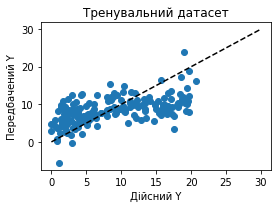

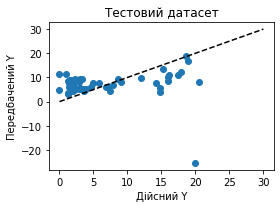

In [17]:
plt.figure(figsize=(4, 3))
plt.title("Тренувальний датасет")
plt.scatter(y_train, y_pred)
plt.plot([0, 30], [0, 30], "--k")
plt.axis("tight")
plt.xlabel("Дійсний Y")
plt.ylabel("Передбачений Y")
plt.tight_layout()

plt.figure(figsize=(4, 3))
plt.title("Тeстовий датасет")
plt.scatter(y_test, y_pred_test_1)
plt.plot([0, 30], [0, 30], "--k")
plt.axis("tight")
plt.xlabel("Дійсний Y")
plt.ylabel("Передбачений Y")
plt.tight_layout()

In [18]:
test_errors_1 = []
test_errors_2 = []
for i in range(50):
    test_errors_1.append((np.linalg.norm(y_pred_test_1[i] - y_test[i]))**2)
    test_errors_2.append((np.linalg.norm(y_pred_test_2[i] - y_test[i]))**2)

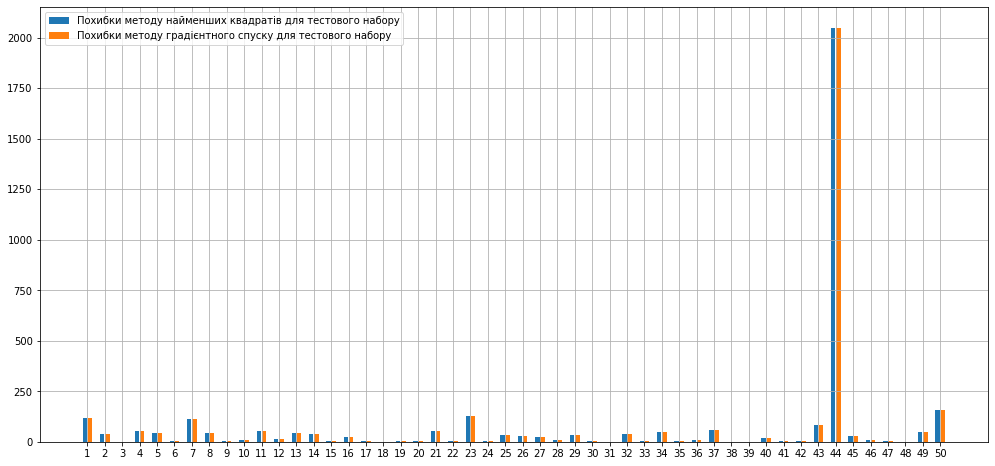

In [19]:
plt.figure(figsize=(17, 8))
ax = plt.subplot()

ax.bar(np.arange(1, y_test.shape[0]+1)-0.15, test_errors_1, width=0.25,
       label="Похибки методу найменших квадратів для тестового набору")
ax.bar(np.arange(1, y_test.shape[0]+1)+0.15, test_errors_2, width=0.25,
       label="Похибки методу градієнтного спуску для тестового набору")

plt.xticks(range(1, y_test.shape[0]+1), range(1, y_test.shape[0]+1))
plt.legend(loc='upper left')
plt.grid()
plt.show()